# Supernova spectrum matching and classification notebook

### Import packages needed and define a stats function

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from functions import ProcessSpectra, BinSpec, split, get_classification, dered, get_spec_matches, target_wavelength_range
from glob import glob
from joblib import dump, load
import os

In [55]:
def get_z_stats(get_sn = False, get_type = False, plot = True ):
    '''
    Returns the stats for either a particular supernova as defined by get_sn,
    or a particular type as defined by get_type.
    Output is one tuple and two arrays; 
    
    [0] = (median, mean, std)
    [1] = redshift array
    [2] = weights array for plt.hist weights argument
    '''
    
    
    # set the empty lists
    stats = []
    w = []
    
    # set parameters for a supernova or a type
    if get_sn:
        sn_matches = [get_sn]
        list_to_use = sne
        
    if get_type:
        sn_matches = set(sne)
        list_to_use = types
     
    # iterate through the lists to get the redshifts that match the conditions
    for this_sn in sn_matches:        
        for idx ,obj in enumerate(list_to_use):
            
            if (obj == this_sn) or (obj == get_type):
                stats.append(zs[idx])
                w. append(sorted_scores[idx])
                
    # normalise the scores to the score in the list. This is for 'weights' in plt.hist            
    w =  ( w / max(sorted_scores) ) ** 4 
    
    # cast as numpy array
    stats = np.array(stats)
    w = np.array(w)
    
    if plot:
        plt.hist(stats, weights = w, color = 'k', facecolor = 'tab:green', zorder = 0, rwidth= 0.9, density = True)
        plt.axvline(x = np.average(stats, weights = w), linestyle = 'dashed' , color = 'k')
        plt.axvline(x = np.average(stats, weights = w) + np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.axvline(x = np.average(stats, weights = w) - np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.xlabel('Redshift')
        plt.ylabel('weighted counts')
    
    return (np.median(stats), np.average(stats, weights = w), np.std(stats) ), stats, w

def plot(spectrum, E = False, i = 15):
    print(f'Top {i} matches to {os.path.basename(spectrum)}')
    
    x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

    if E:
        y = dered(x, y, 3.1, E)

    ref_lam = 6000

    scale = y[np.argmin(abs(x - ref_lam))]
    y = y / scale

    plt.figure(figsize = (15,19))
    used =[]
    n = 0
    for i, spec in enumerate(all_specs):
        #if i <15:
        if (sne[i] not in used) and (n < 15):
            used.append(sne[i])
        
            plt.subplot(5,3, n + 1)
            plt.plot(x, y)
    
            x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
            x_ = x_ * (1 + zs[i])
    
            scale = y_[np.argmin(abs(x_ - ref_lam))]
            y_ = y_ / scale
        
            fit_score = sorted_scores[i] / max(sorted_scores)
            plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

            plt.legend(frameon = False)
            plt.minorticks_on()
            # this messes up if i changes
            if n in  [0, 3, 6, 9, 12]:
                plt.ylabel('Scaled flux')
            if n in [14, 13 ,12]:
                plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        
            n+=1
        #else:
        #    break

Load the model and the list of classifications for the spectra in the model

In [56]:
# Load the model
model_location = './models/Gr13_KNNClassification_model.k=1000.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.Gr13.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

## --User defined--
### Set the input spectrum

In [57]:
# For a single spectrum
specname = 'SN2019dwa_20190521.w.txt'

spectrum = f'./for_classification/{specname}'

# set extinction and the redshift, if known
E = False
redshift = False
pad = True

In [58]:
# For multiple spectra in a folder
folder = '/Users/sprentice/Documents/Pessto_run_feb21/4Feb/for_classification/'

# print the file names in order
spectra = glob(folder +'*.asci')
for idx, i in enumerate(spectra):
    print(idx, os.path.basename(i ) )

# choose the object and set extinction and the redshift, if known
index = 6
E = False
redshift = False
pad = False

# set spectum name ad if necessary pad and deredden
spectrum = spectra[index]

# print the chose spectrum for classification
print(f'\nclassifying {os.path.basename(spectrum) }')

0 tATLAS21cii_20210204_Gr13_Free_slit1.0_1_f.asci
1 tAT2021bon_20210204_Gr13_Free_slit1.0_1_f.asci
2 tAT2021bix_20210204_Gr13_Free_slit1.5_1_f.asci
3 tAT2021bnb_20210204_Gr13_Free_slit1.0_1_f.asci
4 tAT2021bsb_20210204_Gr13_Free_slit1.0_1_f.asci
5 tAT2021bsf_20210204_Gr13_Free_slit1.0_1_f.asci
6 tAT2021alk_20210204_Gr13_Free_slit1.0_1_f.asci
7 tAT2021bpn_20210204_Gr13_Free_slit1.0_1_f.asci
8 tAT2021bsx_20210204_Gr13_Free_slit1.0_1_f.asci
9 tAT2021bpd_20210204_Gr13_Free_slit1.0_1_f.asci

classifying tAT2021alk_20210204_Gr13_Free_slit1.0_1_f.asci


# Get the best match and the scores for all the matches

### To get the classification matches, call the _get_classification_ function with the following arguments

best_match, indices, scores = get_classification( spectrum location, model, E, pad)

-- _spectrum location_ is a string of the spectrum location.

-- _model_ is the model imported earlier, usually just called clf.

-- _E_ is either a float or False. If omitted, _E_ = False.

-- _pad_ is a boolean set to False by default and pads out spectra that are shorter than _target_wavelength_range_

In [59]:
best_match, indices, scores = get_classification(spectrum, clf, E = E, pad = pad)
best_match_properties = split(best_match)[0]
best_match_properties
print(f'The best match is {best_match_properties[0]} {best_match_properties[1]} (t = {best_match_properties[3]} d) at z = {best_match_properties[2]}')

The best match is Ia SN2013dy (t = 6.88 d) at z = 0.09


### Sort all the matches by score then return them in a list

In [60]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))

a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

# list the top 15 matches
a[:15]

[('Ia', 'SN2013dy', 0.09, 6.88, 'Ia_SN2013dy_6.88_.txt'),
 ('Ia', 'SN2013dy', 0.092, 6.88, 'Ia_SN2013dy_6.88_.txt'),
 ('Ia', 'SN2013dy', 0.088, 6.88, 'Ia_SN2013dy_6.88_.txt'),
 ('Ia', 'SN2011fe', 0.088, 4.07, 'Ia_SN2011fe_4.07_.txt'),
 ('Ia', 'SN2012fr', 0.09, 8.75, 'Ia_SN2012fr_8.75_.txt'),
 ('Ia', 'SN2011fe', 0.086, 4.07, 'Ia_SN2011fe_4.07_.txt'),
 ('Ia', 'SN2011fe', 0.09, 4.07, 'Ia_SN2011fe_4.07_.txt'),
 ('Ia', 'SN2013dy', 0.094, 6.88, 'Ia_SN2013dy_6.88_.txt'),
 ('Ia', 'SN2011fe', 0.084, 4.07, 'Ia_SN2011fe_4.07_.txt'),
 ('Ia', 'SN2013dy', 0.086, 6.88, 'Ia_SN2013dy_6.88_.txt'),
 ('Ia', 'SN2011fe', 0.09, -0.12, 'Ia_SN2011fe_-0.12_.txt'),
 ('Ia', 'SN2005cf', 0.092, 4.97, 'Ia_SN2005cf_4.97_.txt'),
 ('Ia', 'SN2011fe', 0.088, -0.12, 'Ia_SN2011fe_-0.12_.txt'),
 ('Ia', 'SN2005cf', 0.092, 3.97, 'Ia_SN2005cf_3.97_.txt'),
 ('Ia', 'SN2005cf', 0.09, 5.96, 'Ia_SN2005cf_5.96_.txt')]

In [61]:
# Quickly show the unique types and objects
print(set(types), set(sne))

{'Ia', 'SLSN-I', 'IIb', 'Ic-7', 'Ic-6', 'Ib', 'Ia-91T'} {'SN2001V', 'SN2008ax', 'SN1999ex', 'SN2012fr', 'iPTF13bvn', 'SN2005cf', 'SN2011fe', 'SN2003du', 'SN2010md', 'SN2013dy', 'SN2007gr', 'SN1999aa', 'SN2011dh', 'SN1994I', 'SN2009jf'}


## Plot the best 15 matches

Top 15 matches to tAT2021alk_20210204_Gr13_Free_slit1.0_1_f.asci


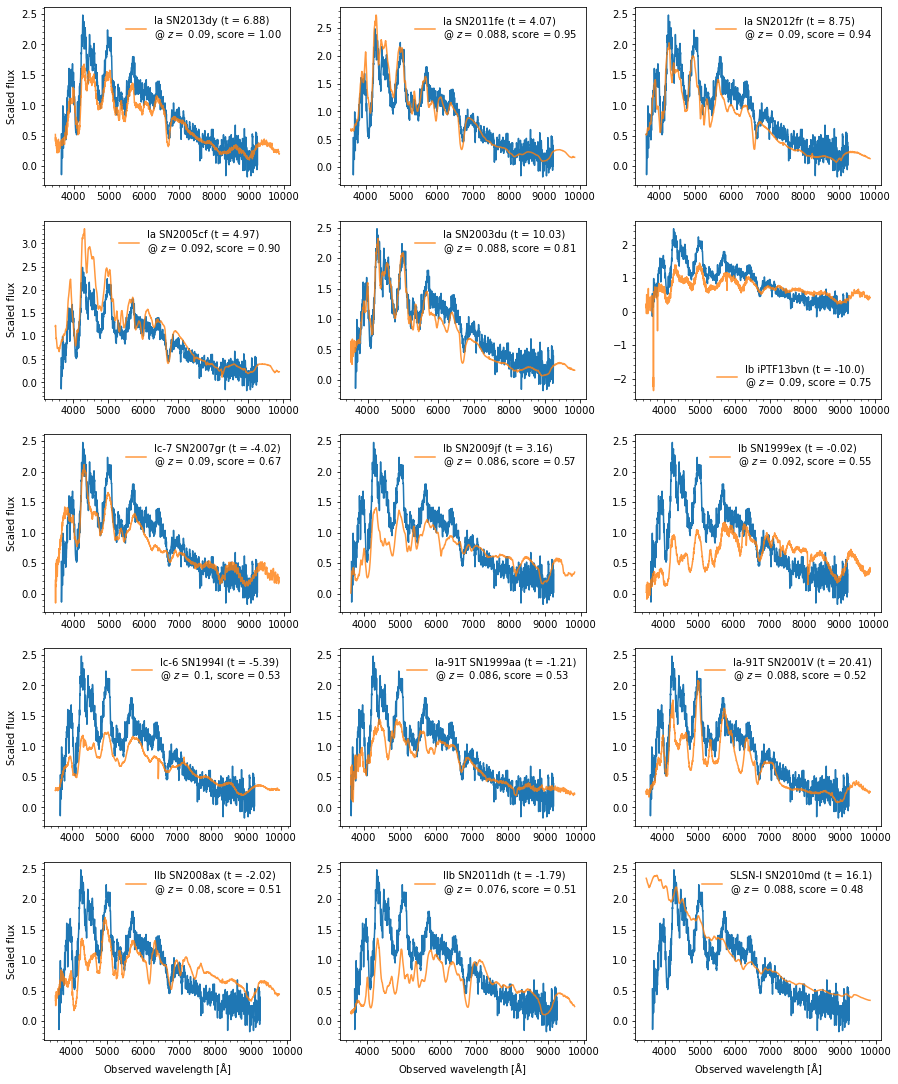

In [62]:
plot(spectrum, E = E, i = 15)

# spectrum match plot saves to the location of the spectrum
#plt.savefig(spectrum+'.pdf', bbox_inches='tight')

## Plot the redshift distributions
The first selects on SN type, be careful with this as although the bins components are weighted according to score
having a lot in one bin with a marginally lower score than the best fit gives a shifted average e.g., the sampling is not uniform!

### First from the best match object

SN2013dy z = 0.092 +-0.009 (std not weighted)


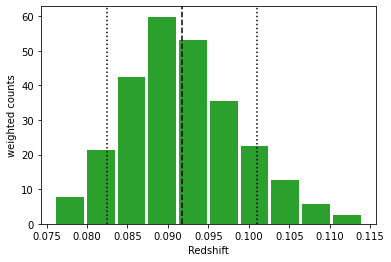

In [63]:
sn = sne[0]
z_stats = get_z_stats(get_sn = sn)
print(f'{sn} z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Next from a selected SN type

z = 0.068 +-0.012 (std not weighted)


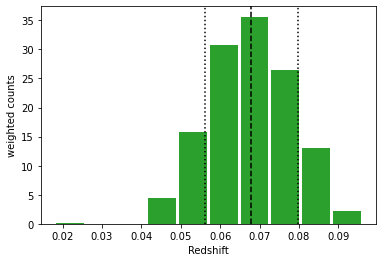

In [161]:
z_stats = get_z_stats(get_type = 'Ia')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Plot all the redshifts and phases

Text(0.5, 0, 'Redshift')

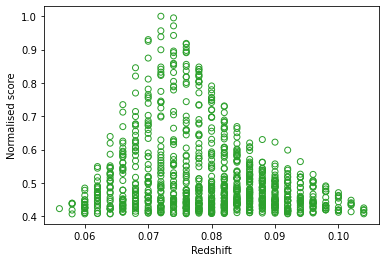

In [29]:
plt.scatter( zs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'tab:green')
plt.ylabel('Normalised score')
plt.xlabel('Redshift')

Text(0.5, 0, 'Epoch [days]')

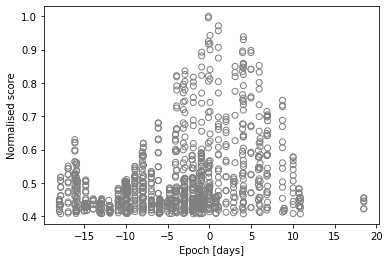

In [30]:
plt.scatter(epochs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'grey')
plt.ylabel('Normalised score')
plt.xlabel('Epoch [days]')

The same again but for an individual SN. Again the bin components are weighted according to score. This should be a little better than filtering on SN types

## Plot individual SN matches.
Simply define a part of the SN name to include in the search

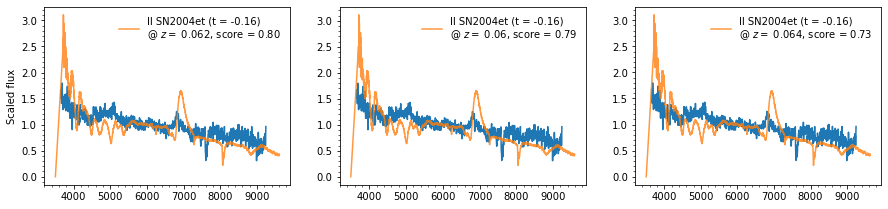

In [48]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

if E:
    y = dered(x, y, 3.1, E)

scale = y[np.argmin(abs(x-6000))]
y = y / scale

# need a rising index
n= 0

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if '04et' in spec and n < 15: 
        
        plt.subplot(5,3, n + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - 6000))]
        y_ = y_ / scale
    
        fit_score = sorted_scores[i] / max(sorted_scores)
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        
        # this messes up if the limit of n changes
        if n in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if n in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        #plt.show()
        n+=1
#plt.savefig(f'{spectrum}.pdf')

## If you need to quickly match some galaxy lines

(6500.0, 6600.0)

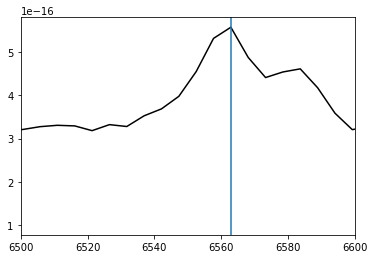

In [159]:
x, y = np.loadtxt(spectrum, unpack=True)
x = x / 1.065

plt.plot(x,y, color = 'k')
plt.axvline(x = 6563)
plt.axvline(x = 4861)
plt.axvline(x = 4340)
plt.xlim(6500, 6600)